In [67]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import channels
from importlib import reload
from scipy.integrate import quad
from scipy import signal

63 2.1166248611409806


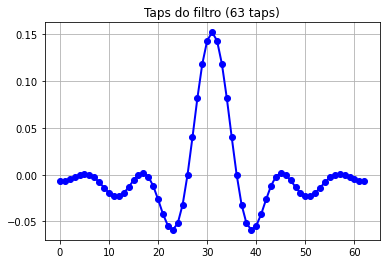

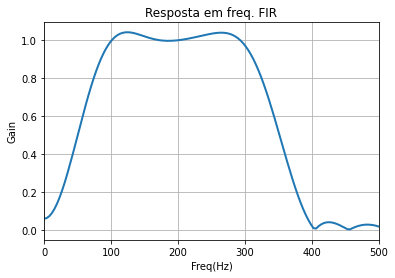

In [68]:
sample_rate = 4000
n_samples = 16e3

nyq_rate = sample_rate/2.0

width = 100.0/nyq_rate #velocidade de transicao da banda passante para de parada

ripple_dB = 30.0 # atenuacao na banda de parada

N, beta = signal.kaiserord(ripple_dB, width) #geracao dos parametros da janela

print(N, beta)

cutoff_hz = [50.0, 350.0] #frequencias de corte. Se quiser apenas uma, colocar apenas um valor

#se quiser outro tipo de filtro (passa banda, passa baixa ...) alterar pass_zero

taps = signal.firwin(N, [x/nyq_rate for x in cutoff_hz], window=('kaiser', beta), pass_zero='bandpass')

plt.figure(1)
plt.plot(taps, 'bo-', linewidth=2)
plt.title('Taps do filtro (%d taps)' % N)
plt.grid(True)

plt.figure(2)
plt.clf()
w, h = signal.freqz(taps, worN=512)
plt.plot((w/np.pi)*nyq_rate, np.abs(h), linewidth=2)
plt.xlabel('Freq(Hz)')
plt.ylabel('Gain')
plt.title('Resposta em freq. FIR')
plt.xlim(0.0, 500.0)
plt.grid(True)

In [69]:
def rand_bin(p):
   
    bits = "0b"
    for i in range(p):
        temp = str(random.randint(0, 1))
        bits += temp
         
    return(bin(int(bits,2)))


def inversegrayCode(bitstream):
    inv = 0;
    #bin(int(bitstream))
     
    # Faz xor ate
    # n ser zero
    while(bitstream):
        inv = inv ^ bitstream;
        bitstream = bitstream >> 1;
    return inv;

def binary_to_gray_op(n):
   n = int(n, 2)
   n ^= (n >> 1)

   return bin(n)

In [70]:
N = 10
bitstream = [rand_bin(2) for x in range(N//2)]
print(bitstream)
print(inversegrayCode(int(bitstream[0],2)))
radius_stream = [inversegrayCode(int(binary_to_gray_op(bitstream[x]),2)) for x in range(N//2)]
print(radius_stream)
print(type(binary_to_gray_op(bitstream[0])))
print([binary_to_gray_op(bitstream[x]) for x in range(N//2)])
print([inversegrayCode(int(binary_to_gray_op(bitstream[x]),2)) for x in range(N//2)])
temp = [np.unpackbits(np.array([x], dtype=np.uint8), axis=0, count=-6,  bitorder='little') for x in [1,2,3]] 
print(temp)
temp = np.fliplr(temp).flatten()
print(temp)


['0b11', '0b11', '0b1', '0b11', '0b10']
2
[3, 3, 1, 3, 2]
<class 'str'>
['0b10', '0b10', '0b1', '0b10', '0b11']
[3, 3, 1, 3, 2]
[array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([1, 1], dtype=uint8)]
[0 1 1 0 1 1]


In [71]:
def MPSK_reference(M):
    m = np.arange(0,M)
    I = 1/np.sqrt(2)*np.cos(m/M*2*np.pi)
    Q = 1/np.sqrt(2)*np.sin(m/M*2*np.pi)
    ref_constellation = I + 1j*Q
    return ref_constellation

def pi_4_PSK_reference(M):
    m = np.arange(1, M+1)
    I = np.cos((2*m-1)*np.pi/4)
    Q = np.sin((2*m-1)*np.pi/4)
    ref_constellation = I + 1j*Q
    return ref_constellation

In [102]:
def iqDetector(receivedSyms, reference_const):
    XA = np.column_stack((np.real(receivedSyms), np.imag(receivedSyms)))
    XB = np.column_stack((np.real(reference_const), np.imag(reference_const)))
    
    d=cdist(XA,XB,'euclidean')
    detectSyms=np.argmin(d, axis=1)
    
    return detectSyms

In [73]:
def MPSK_mapping(in_sym, constellation):
    mapped = constellation[in_sym]
    return mapped

In [74]:
def const_plotting(const_ref, mod_sig):
    plt.plot(np.real(const_ref), np.imag(const_ref), "r*")
    plt.plot(np.real(mod_sig), np.imag(mod_sig), "b*")


In [75]:
reload(channels)

M = 4 #M-ary symbols
Nsym = 50
const_ref = MPSK_reference(M)
print(const_ref)
in_sym=np.random.randint(0, M, size=Nsym)
print(in_sym)
mod_QPSK =  MPSK_mapping(in_sym, const_ref)

## Aplicacao do canal de reyleigh 

h_abs = channels.rayleigh_channel(Nsym)
hs = h_abs*mod_QPSK
r = awgn(hs, 5)
plt.plot(np.real(r), np.imag(r), "g*")

print(mod_QPSK)

r = r/h_abs
demod = iqDetector(r, const_ref)
print(demod)
const_plotting(const_ref, mod_QPSK)

[ 7.07106781e-01+0.00000000e+00j  4.32978028e-17+7.07106781e-01j
 -7.07106781e-01+8.65956056e-17j -1.29893408e-16-7.07106781e-01j]
[3 0 2 0 1 0 2 2 1 0 0 0 0 3 1 3 0 1 3 3 0 3 0 2 3 0 1 1 1 0 1 3 1 0 1 0 0
 2 3 3 1 2 2 0 3 3 2 3 3 2]


NameError: name 'awgn' is not defined

In [76]:
from scipy.special import erfc

def psk_awgn(M, EbN0dB):
    gamma_s = np.log2(M)*(10**(EbN0dB/10))
    gamma_b = gamma_s/np.log2(M)
    q = 0.5 * erfc(np.sqrt(gamma_b))
    q = 2*q-q**2
    return q

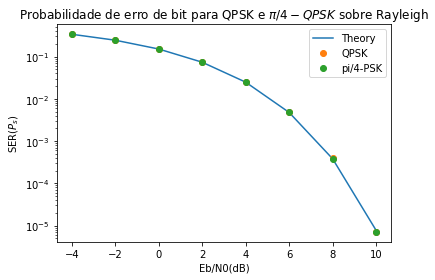

In [112]:
## BER para awgn

Nsym = 10**7 #Numero de simbolos para o teste
EbN0dB = np.arange(start=-4, stop=12, step=2)
M = 4
in_sym=np.random.randint(0, M, size=Nsym)

const_ref_qpsk = MPSK_reference(M)
const_ref_pi_4 = pi_4_PSK_reference(M)
k=np.log2(M)
EsN0dBs = 10*np.log10(k)+EbN0dB

modulatedSyms_qpsk = MPSK_mapping(in_sym, const_ref_qpsk)
modulatedSyms_pi_4 = MPSK_mapping(in_sym, const_ref_pi_4)

SER_sim_ray_qpsk = np.zeros(len(EbN0dB))
SER_sim_ray_pi_4 = np.zeros(len(EbN0dB))
#SER_sim_ray_fir = np.zeros(len(EbN0dB))


for i, EsN0dB in enumerate(EsN0dBs):
    
    r_qpsk = channels.awgn_channel(modulatedSyms_qpsk, EsN0dB)
    r_pi_4 = channels.awgn_channel(modulatedSyms_pi_4, EsN0dB)
    
    #r_fir = signal.lfilter(taps, 1.0, modulatedSyms_pi_4)
    #r_fir = awgn(r_fir, EsN0dB)
    
    y_qpsk = r_qpsk
    y_pi_4 = r_pi_4

    detectedSyms_qpsk = iqDetector(y_qpsk, const_ref_qpsk)
    detectedSyms_pi_4 = iqDetector(y_pi_4, const_ref_pi_4)
    #detectedSyms_fir = iqDetector(r_fir, const_ref_pi_4)

    SER_sim_ray_qpsk[i] = np.sum(detectedSyms_qpsk != in_sym)/Nsym
    SER_sim_ray_pi_4[i] = np.sum(detectedSyms_pi_4 != in_sym)/Nsym
    #SER_sim_ray_fir[i] = np.sum(detectedSyms_fir != in_sym)/Nsym


SER_theory_awgn = psk_awgn(M, EbN0dB)
plt.semilogy(EbN0dB, SER_theory_awgn, '-')
plt.semilogy(EbN0dB, SER_sim_ray_qpsk, 'o')
plt.semilogy(EbN0dB, SER_sim_ray_pi_4, 'o')
#plt.semilogy(EbN0dB, SER_sim_ray_fir, 'o')


plt.xlabel("Eb/N0(dB)")
plt.ylabel('SER($P_s$)')
plt.title('Probabilidade de erro de bit para QPSK e $\pi/4-QPSK$ sobre Rayleigh')
plt.legend(["Theory", "QPSK", "pi/4-PSK"])
plt.show()

In [78]:
def mgf_rayleigh(g,gamma):
    fun = lambda x: 1/(1+(g*gamma/(np.sin(x)**2)))
    return fun

def psk_ray_theory(M, EbN0dB):
    gamma = np.log2(M)*(10**(EbN0dB/10))
    SER = np.zeros(len(gamma))
    g = (np.sin(np.pi/M))**2
    for i, gamma_s in enumerate(gamma):
        (y,_) = quad(mgf_rayleigh(g,gamma_s),0,np.pi*(M-1)/M)
        SER[i] = (1/np.pi)*y
    return SER

In [79]:
## BER para rayleigh

Nsym = 10**6 #Numero de simbolos para o teste
EbN0dB = np.arange(start=-4, stop=12, step=2)
M = 4
in_sym=np.random.randint(0, M, size=Nsym)

const_ref_qpsk = MPSK_reference(M)
const_ref_pi_4 = pi_4_PSK_reference(M)
k=np.log2(M)
EsN0dBs = 10*np.log10(k)+EbN0dB

modulatedSyms_qpsk = MPSK_mapping(in_sym, const_ref_qpsk)
modulatedSyms_pi_4 = MPSK_mapping(in_sym, const_ref_pi_4)

SER_sim_ray_qpsk = np.zeros(len(EbN0dB))
SER_sim_ray_pi_4 = np.zeros(len(EbN0dB))


for i, EsN0dB in enumerate(EsN0dBs):
    h_abs = channels.rayleigh_channel(Nsym)
    hs_qpsk = h_abs*modulatedSyms_qpsk
    hs_pi_4 = h_abs*modulatedSyms_pi_4
    
    r_qpsk = awgn(hs_qpsk, EsN0dB)
    r_pi_4 = awgn(hs_pi_4, EsN0dB)
    
    y_qpsk = r_qpsk/h_abs
    y_pi_4 = r_pi_4/h_abs

    detectedSyms_qpsk = iqDetector(y_qpsk, const_ref_qpsk)
    detectedSyms_pi_4 = iqDetector(y_pi_4, const_ref_pi_4)
    SER_sim_ray_qpsk[i] = np.sum(detectedSyms_qpsk != in_sym)/Nsym
    SER_sim_ray_pi_4[i] = np.sum(detectedSyms_pi_4 != in_sym)/Nsym


SER_theory_ray = psk_ray_theory(M, EbN0dB)
plt.semilogy(EbN0dB, SER_theory_ray, '-')
plt.semilogy(EbN0dB, SER_sim_ray_qpsk, 'o')
plt.semilogy(EbN0dB, SER_sim_ray_pi_4, '+')

plt.xlabel("Eb/N0(dB)")
plt.ylabel('SER($P_s$)')
plt.legend(["Theory", "QPSK", "pi/4-PSK"])
plt.show()

NameError: name 'awgn' is not defined

In [80]:
def mgf_rician(K_dB,g,gamma):
    K = 10**(K_dB/10)
    fun = lambda x: ((1+K)*np.sin(x)**2)/((1+K)*np.sin(x)**2+g*gamma)*\
    np.exp(-K*g*gamma/((1+K)*np.sin(x)**2+g*gamma))
    return fun

def psk_rician_theory(K_dB,M, EbN0dB):
    gamma = np.log2(M)*(10**(EbN0dB/10))
    SER = np.zeros(len(gamma))
    g = (np.sin(np.pi/M))**2
    for i, gamma_s in enumerate(gamma):
        (y,_) = quad(mgf_rician(K_dB, g,gamma_s),0,np.pi*(M-1)/M)
        SER[i] = (1/np.pi)*y
    return SER

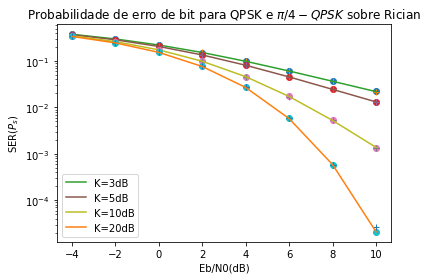

In [115]:
## BER para Rician

Nsym = 10**6 #Numero de simbolos para o teste
EbN0dB = np.arange(start=-4, stop=12, step=2)
M = 4
in_sym=np.random.randint(0, M, size=Nsym)

const_ref_qpsk = MPSK_reference(M)
const_ref_pi_4 = pi_4_PSK_reference(M)
k=np.log2(M)
K_dBs = [3,5,10,20]
EsN0dBs = 10*np.log10(k)+EbN0dB

modulatedSyms_qpsk = MPSK_mapping(in_sym, const_ref_qpsk)
modulatedSyms_pi_4 = MPSK_mapping(in_sym, const_ref_pi_4)
SER_sim_rice_qpsk = np.zeros(len(EbN0dB))
SER_sim_rice_pi_4 = np.zeros(len(EbN0dB))



for j, K_dB in enumerate(K_dBs):
    

    for i, EsN0dB in enumerate(EsN0dBs):
        h_abs = channels.rician_channel(K_dB, Nsym)
        hs_qpsk = h_abs*modulatedSyms_qpsk
        hs_pi_4 = h_abs*modulatedSyms_pi_4

        r_qpsk = awgn(hs_qpsk, EsN0dB)
        r_pi_4 = awgn(hs_pi_4, EsN0dB)

        y_qpsk = r_qpsk/h_abs
        y_pi_4 = r_pi_4/h_abs

        detectedSyms_qpsk = iqDetector(y_qpsk, const_ref_qpsk)
        detectedSyms_pi_4 = iqDetector(y_pi_4, const_ref_pi_4)
        SER_sim_rice_qpsk[i] = np.sum(detectedSyms_qpsk != in_sym)/Nsym
        SER_sim_rice_pi_4[i] = np.sum(detectedSyms_pi_4 != in_sym)/Nsym
        
    plt.semilogy(EbN0dB, SER_sim_rice_pi_4, 'o')
    plt.semilogy(EbN0dB, SER_sim_rice_qpsk, '+')
    SER_theory_rician = psk_rician_theory(K_dB, M, EbN0dB)
    plt.semilogy(EbN0dB, SER_theory_rician, '-', label='K='+str(K_dB)+'dB')


plt.xlabel("Eb/N0(dB)")
plt.ylabel('SER($P_s$)')
plt.title('Probabilidade de erro de bit para QPSK e $\pi/4-QPSK$ sobre Rician')

plt.legend()

plt.show()

In [82]:
#Código Felipe

def qpsk_mod(bitstream, fc, OF):


  L = 2*OF #Amostragens em cada símbolo (QPSK tem 2 bits em cada símbolo)
  N = len(bitstream)
  #radius_stream = [inversegrayCode(int(binary_to_gray_op(bitstream[x]),2)) for x in range(N)]
  radius_stream = [inversegrayCode(int(bitstream[x],2)) for x in range(N)]
  bits_unpack = [np.unpackbits(np.array(inversegrayCode(radius_stream[x]), dtype=np.uint8), axis=0, count=-6,  bitorder='little') for x in range(len(radius_stream))] 
  #print(bits_unpack)
  bits_unpack = np.fliplr(bits_unpack).flatten()
  #radius_stream = [int(bitstream[x],2) for x in range(N)]
  #print(bitstream)
  #print(radius_stream)
  #I = bitstream[0::2] #Simbolos pares vao na componente em fase
  #print("valor I antes do upfirdn:", I)
  #Q = bitstream[1::2] #Simbolos impares vao na componente em quadratura
  #print("valor Q antes do upfirdn:", Q)
  from scipy.signal import upfirdn
  radius_stream = upfirdn(h=[1]*L, x=radius_stream,up=L)
  #I = upfirdn(h=[1]*L, x=I,up=L) #Codificador NRZ, realiza também um upsampling no tamanho de L
  #print("valor I depois do upfirdn:", I)
  #Q = upfirdn(h=[1]*L, x=Q,up=L) # Sinal aqui ainda está em banda básica
  #print("valor I depois do upfirdn:", Q)
  fs = OF*fc  # frequencia de amostragem ja com a sobre amostragem
  t = np.arange(0, len(radius_stream)/fs, 1/fs)
  
  
  #I = bin(I)
  #print(I)

  I = np.around(np.cos((radius_stream-1)*np.pi/2))
  Q = np.around(np.sin((radius_stream-1)*np.pi/2))
  #print(radius_stream)
  #print("valor I depois do upfirdn:", I)
  #print("valor de q depois : ", Q)



  I_t = I*np.cos(2*np.pi*fc*t)  #Aqui é feito agora a expressão para banda passante
  Q_t = -Q*np.sin(2*np.pi*fc*t) 
  s_t = I_t + Q_t

  result = dict()
  result['bits_unpack'] = bits_unpack
  result['s(t)'] = s_t  #Sinal QPSK
  result['I'] = I #Sinal em fase e em banda básica
  result['I(t)'] = I_t #Sinal em fase e em banda passante
  result['Q'] = Q #Sinal em quadratura e em banda básica
  result['Q(t)'] = Q_t #Sinal em quadratura e em banda passante
  result['t'] = t #componente temporal
  result['complex'] = I + 1j*Q
  return result

In [83]:
def qpsk_dem(s_t, fc, OF):
  
  fs = OF*fc
  L = 2*OF
  t = np.arange(0, len(s_t)/fs, 1/fs)

  I = s_t*np.cos(2*np.pi*fc*t) #multiplicando por uma função de base em fase com o transmissor
  Q = -s_t*np.sin(2*np.pi*fc*t)

  
  x1 = np.convolve(I, np.ones(L)) #lembre se que a convolução de um sinal por um pulso unitario de duração T é a integral naquele intervalo
  x2 = np.convolve(Q, np.ones(L))

  x1_sam = np.around(x1[L-1::L]) #faz com que o sinal seja amostrado sempre em intervalos de K(L-1), em que K é o numero do bit
  x2_sam = np.around(x2[L-1::L])
  

  bits_out = np.zeros(2*len(x1_sam))
  bits_out[0::2] = (x2_sam>0)
  bits_out[1::2] = (x1_sam>0)
  result = dict()
  result['x1'] = x1
  result['x2'] = x2
  result['x1_sam'] = x1_sam
  result['x2_sam'] = x2_sam
  result['bits_out'] = bits_out
  return result

['0b1', '0b0', '0b0', '0b11']


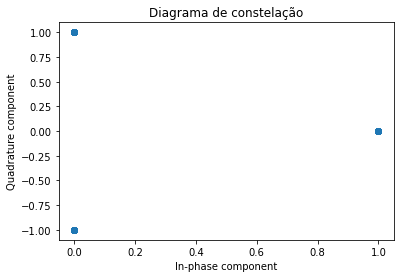

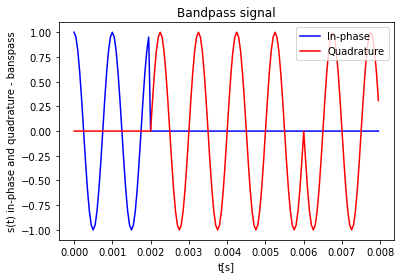

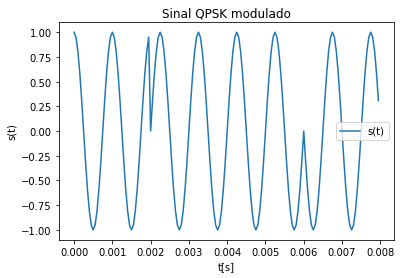

In [84]:
N = 8 #Numero de símbolos para transmissao
fc = 1000 #frequencia da portadora
OF = 20  #fator de sobre-amostragem

#bitstream = np.random.randint(2, size=N)
bitstream = [rand_bin(2) for x in range(N//2)]
print(bitstream)

#bitstream = [0, 1, 0, 0, 0, 1, 1, 1]
QPSK = qpsk_mod(bitstream, fc, OF)

plt.title('Diagrama de constelação')
plt.plot(QPSK['I'], QPSK['Q'], 'o')
plt.ylabel('Quadrature component')
plt.xlabel('In-phase component')
plt.show()


plt.plot(QPSK['t'], QPSK['I(t)'], 'b')
plt.plot(QPSK['t'], QPSK['Q(t)'], 'r')
plt.legend(['In-phase', "Quadrature"])
plt.ylabel('s(t) in-phase and quadrature - banspass')
plt.xlabel('t[s]')
plt.title('Bandpass signal')
plt.show()

plt.plot(QPSK['t'], QPSK['s(t)'])
plt.legend(['s(t)'])
plt.title('Sinal QPSK modulado')
plt.ylabel('s(t)')
plt.xlabel('t[s]')
plt.show()

[0. 1. 0. 0. 0. 0. 1. 0.]
['0b1', '0b0', '0b0', '0b11']
[0 1 0 0 0 0 1 1]


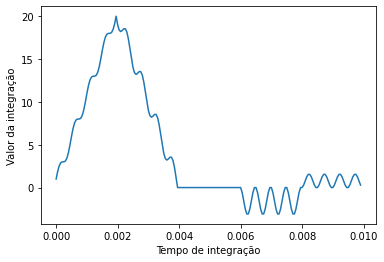

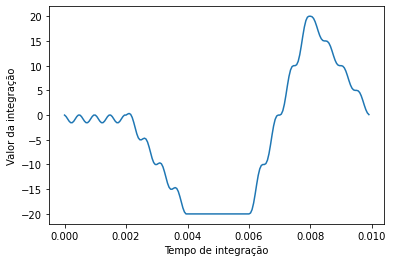

In [85]:
result = qpsk_dem(QPSK['s(t)'], fc, OF)
t_conv = np.arange(0, len(result['x1'])/(fc*OF), 1/(fc*OF))
#print(result['x1_sam'])
#print(result['x2_sam'])
print(result['bits_out'])
print(bitstream)
print(QPSK['bits_unpack'])
plt.plot(t_conv, result['x1'])
plt.ylabel("Valor da integração")
plt.xlabel("Tempo de integração")

plt.show()
plt.plot(t_conv, result['x2'])
plt.ylabel("Valor da integração")
plt.xlabel("Tempo de integração")
plt.show()
#print(inversegrayCode(int(result['bits_out'])))

In [86]:
# ['0b11', '0b0', '0b0', '0b1']

def pi_4_qpsk_mod(bitstream, fc, OF):


  L = 2*OF #Amostragens em cada símbolo (QPSK tem 2 bits em cada símbolo)
  I = bitstream[0::2] #Simbolos pares vao na componente em fase
  #print("valor I antes do upfirdn:", I)
  Q = bitstream[1::2] #Simbolos impares vao na componente em quadratura
  #print("valor Q antes do upfirdn:", Q)
  from scipy.signal import upfirdn
  I = upfirdn(h=[1]*L, x=2*I-1,up=L) #Codificador NRZ, realiza também um upsampling no tamanho de L
  #print("valor I depois do upfirdn:", I)
  Q = upfirdn(h=[1]*L, x=2*Q-1,up=L) # Sinal aqui ainda está em banda básica
  #print("valor I depois do upfirdn:", I)
  fs = OF*fc  # frequencia de amostragem ja com a sobre amostragem
  t = np.arange(0, len(I)/fs, 1/fs)

  I_t = I*np.cos(2*np.pi*fc*t)  #Aqui é feito agora a expressão para banda passante
  Q_t = -Q*np.sin(2*np.pi*fc*t) 
  s_t = I_t + Q_t

  result = dict()
  result['s(t)'] = s_t  #Sinal QPSK
  result['I'] = I #Sinal em fase e em banda básica
  result['I(t)'] = I_t #Sinal em fase e em banda passante
  result['Q'] = Q #Sinal em quadratura e em banda básica
  result['Q(t)'] = Q_t #Sinal em quadratura e em banda passante
  result['t'] = t #componente temporal
  return result


In [87]:
def pi_4_qpsk_dem(s_t, fc, OF):
  
  fs = OF*fc
  L = 2*OF
  t = np.arange(0, len(s_t)/fs, 1/fs)

  I = s_t*np.cos(2*np.pi*fc*t) #multiplicando por uma função de base em fase com o transmissor
  Q = -s_t*np.sin(2*np.pi*fc*t)

  x1 = np.convolve(I, np.ones(L)) #lembre se que a convolução de um sinal por um pulso unitario de duração T é a integral naquele intervalo
  x2 = np.convolve(Q, np.ones(L))

  x1_sam = x1[L-1::L] #faz com que o sinal seja amostrado sempre em intervalos de K(L-1), em que K é o numero do bit
  x2_sam = x2[L-1::L]

  bits_out = np.zeros(2*len(x1_sam))
  bits_out[0::2] = (x1_sam>0)
  bits_out[1::2] = (x2_sam>0)
  result = dict()
  result['x1'] = x1
  result['x2'] = x2
  result['x1_sam'] = x1_sam
  result['x2_sam'] = x2_sam
  result['bits_out'] = bits_out
  return result


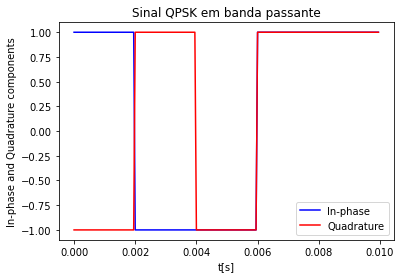

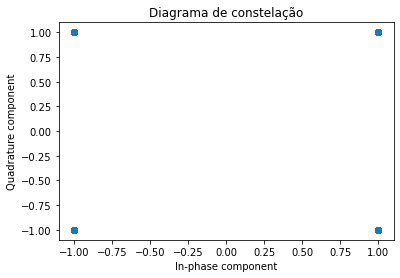

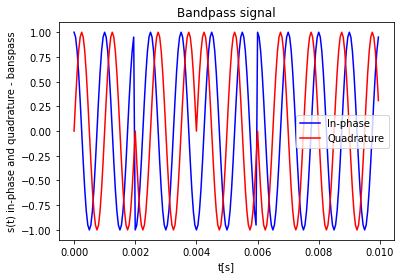

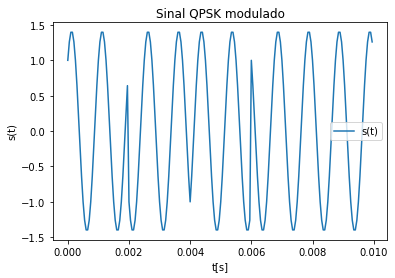

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

N = 10 #Numero de símbolos para transmissao
fc = 1000 #frequencia da portadora
OF = 20  #fator de sobre-amostragem

bitstream = np.random.randint(2, size=N)
QPSK = pi_4_qpsk_mod(bitstream, fc, OF)
#print(bitstream)
plt.plot(QPSK['t'], QPSK['I'], 'b', label='In-phase')
plt.plot(QPSK['t'], QPSK['Q'], 'r', label='Quadrature')
plt.legend(['In-phase', 'Quadrature'])
plt.ylabel('In-phase and Quadrature components')
plt.xlabel('t[s]')
plt.title('Sinal QPSK em banda passante')
plt.show()

plt.title('Diagrama de constelação')
plt.plot(QPSK['I'], QPSK['Q'], 'o')
plt.ylabel('Quadrature component')
plt.xlabel('In-phase component')
plt.show()

plt.plot(QPSK['t'], QPSK['I(t)'], 'b')
plt.plot(QPSK['t'], QPSK['Q(t)'], 'r')
plt.legend(['In-phase', "Quadrature"])
plt.ylabel('s(t) in-phase and quadrature - banspass')
plt.xlabel('t[s]')
plt.title('Bandpass signal')
plt.show()

plt.plot(QPSK['t'], QPSK['s(t)'])
plt.legend(['s(t)'])
plt.title('Sinal QPSK modulado')
plt.ylabel('s(t)')
plt.xlabel('t[s]')
plt.show()

#plt.plot(QPSK['t'], np.angle(QPSK['s(t)']))
#plt.legend(['s(t) - Phase'])
#plt.title('Fase do sinal QPSK modulado')
#plt.ylabel('degree')
#plt.xlabel('t[s]')
#plt.show()

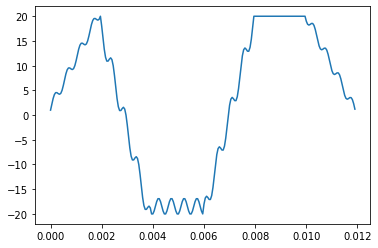

[ 20. -20. -20.  20.  20.]


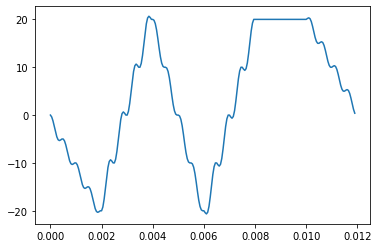

[-20.  20. -20.  20.  20.]
[1. 0. 0. 1. 0. 0. 1. 1. 1. 1.]


In [89]:
result = pi_4_qpsk_dem(QPSK['s(t)'], fc, OF)
t_conv = np.arange(0, len(result['x1'])/(fc*OF), 1/(fc*OF))
L = 2*OF
plt.plot(t_conv, result['x1'])
plt.show()
print(result['x1_sam'])
plt.plot(t_conv, result['x2'])
plt.show()
print(result['x2_sam'])
print(result['bits_out'])

In [90]:
def oqpsk_mod(bitstream, fc, OF):


  L = 2*OF #Amostragens em cada símbolo (QPSK tem 2 bits em cada símbolo)
  I = bitstream[0::2] #Simbolos pares vao na componente em fase
  Q = bitstream[1::2] #Simbolos impares vao na componente em quadratura
  from scipy.signal import upfirdn
  I = upfirdn(h=[1]*L, x=2*I-1,up=L) #Codificador NRZ, realiza também um upsampling no tamanho de L
  Q = upfirdn(h=[1]*L, x=2*Q-1,up=L) # Sinal aqui ainda está em banda básica
  ## A parte que muda para o QPSK é que é acidionado um deslocamento de T/2 no
  ## vetor em quadratura e no vetor em fase é completado os valores com zero 
  I = np.append(I, np.zeros(int(L/2)))
  Q = np.append(np.zeros(int(L/2)), Q)
  fs = OF*fc  # frequencia de amostragem ja com a sobre amostragem
  t = np.arange(0, len(I)/fs, 1/fs)

  I_t = I*np.cos(2*np.pi*fc*t)  #Aqui é feito agora a expressão para banda passante
  Q_t = -Q*np.sin(2*np.pi*fc*t) 
  s_t = I_t + Q_t

  result = dict()
  result['s(t)'] = s_t  #Sinal QPSK
  result['I'] = I #Sinal em fase e em banda básica
  result['I(t)'] = I_t #Sinal em fase e em banda passante
  result['Q'] = Q #Sinal em quadratura e em banda básica
  result['Q(t)'] = Q_t #Sinal em quadratura e em banda passante
  result['t'] = t #componente temporal
  return result

[0 1 1 1 1 0 1 1]


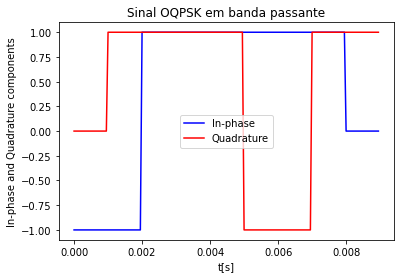

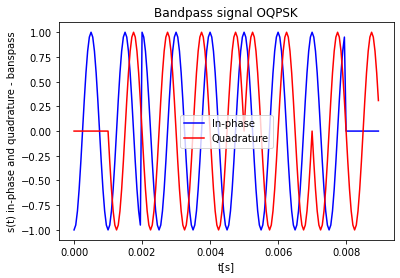

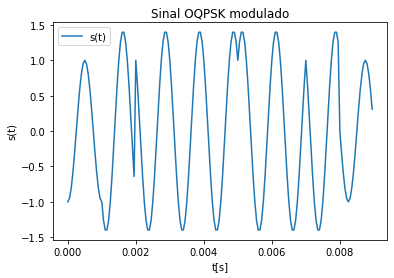

In [91]:

N = 8 #Numero de símbolos para transmissao
fc = 1000 #frequencia da portadora
OF = 20  #fator de sobre-amostragem

bitstream = np.random.randint(2, size=N)
OQPSK = oqpsk_mod(bitstream, fc, OF)
print(bitstream)
plt.plot(OQPSK['t'], OQPSK['I'], 'b', label='In-phase')
plt.plot(OQPSK['t'], OQPSK['Q'], 'r', label='Quadrature')
plt.legend(['In-phase', 'Quadrature'])
plt.ylabel('In-phase and Quadrature components')
plt.xlabel('t[s]')
plt.title('Sinal OQPSK em banda passante')
plt.show()

plt.plot(OQPSK['t'], OQPSK['I(t)'], 'b')
plt.plot(OQPSK['t'], OQPSK['Q(t)'], 'r')
plt.legend(['In-phase', "Quadrature"])
plt.ylabel('s(t) in-phase and quadrature - banspass')
plt.xlabel('t[s]')
plt.title('Bandpass signal OQPSK')
plt.show()

plt.plot(OQPSK['t'], OQPSK['s(t)'])
plt.legend(['s(t)'])
plt.title('Sinal OQPSK modulado')
plt.ylabel('s(t)')
plt.xlabel('t[s]')
plt.show()

In [92]:
def oqpsk_dem(s_t, fc, OF):
  
  fs = OF*fc
  L = 2*OF
  t = np.arange(0, len(s_t)/fs, 1/fs)

  I = s_t*np.cos(2*np.pi*fc*t) #multiplicando por uma função de base em fase com o transmissor
  Q = -s_t*np.sin(2*np.pi*fc*t)

  x1 = np.convolve(I, np.ones(L)) #lembre se que a convolução de um sinal por um pulso unitario de duração T é a integral naquele intervalo
  x2 = np.convolve(Q, np.ones(L))

  x1_sam = x1[L-1:-L-1:L] #faz com que o sinal seja amostrado sempre em intervalos de K(L-1), em que K>0 é o numero do bit
  ## mas note que é necessário começar a contagem a partir do final do vetor de zeros.
  x2_sam = x2[L+int(L/2)-1:int(-L/2)-1:L] #Aqui iniciamos a contagem a partir do tempo T/2 e incrementamos até dar a volta completa

  bits_out = np.zeros(2*len(x1_sam))
  bits_out[0::2] = (x1_sam>0)
  bits_out[1::2] = (x2_sam>0)
  result = dict()
  result['x1'] = x1
  result['x2'] = x2
  result['x1_sam'] = x1_sam
  result['x2_sam'] = x2_sam
  result['bits_out'] = bits_out
  return result

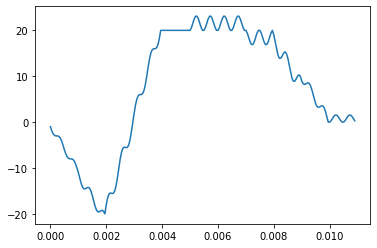

[-20.  20.  20.  20.]


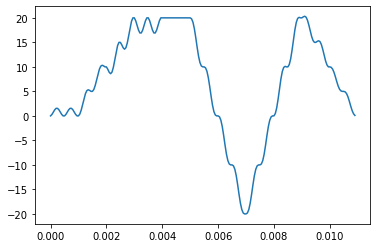

[ 20.  20. -20.  20.]
[0. 1. 1. 1. 1. 0. 1. 1.]


In [93]:
result = oqpsk_dem(OQPSK['s(t)'], fc, OF)
t_conv = np.arange(0, len(result['x1'])/(fc*OF), 1/(fc*OF))
L = 2*OF
plt.plot(t_conv, result['x1'])
plt.show()
print(result['x1_sam'])
plt.plot(t_conv, result['x2'])
plt.show()
print(result['x2_sam'])
print(result['bits_out'])

In [94]:
from locale import windows_locale
def plotWelchPSD(x,fs,fc,ax = None,color='b', label=None):
    """
    Plot PSD of a carrier modulated signal using Welch estimate
    Parameters:
    x : signal vector (numpy array) for which the PSD is plotted
    fs : sampling Frequency
    fc : center carrier frequency of the signal
    ax : Matplotlib axes object reference for plotting
    color : color character (format string) for the plot
    """
    from scipy.signal import welch, windows
    from numpy import log10
    nx = max(x.shape)
    na = 16 # averaging factor to plot averaged welch spectrum
    w = windows.hann(nx//na) #// is for integer floor division
    # Welch PSD estimate with Hanning window and no overlap
    f, Pxx = welch(x,fs,window = w,noverlap=0)
    indices = (f>=fc) & (f<4*fc) # To plot PSD from Fc to 4*Fc
    Pxx = Pxx[indices]/Pxx[indices][0] # normalized psd w.r.t Fc
    ax.plot(f[indices]-fc,10*log10(Pxx),color,label=label) #Plot in the given axes

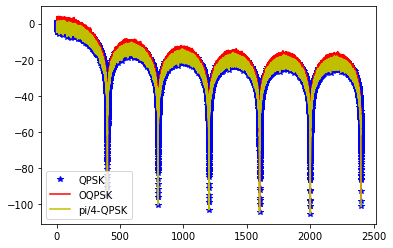

In [95]:
fig,ax = plt.subplots(1,1)

N = 1000000 #Numero de símbolos para transmissao
fc = 800 #frequencia da portadora
OF = 8  #fator de sobre-amostragem
fs = fc*OF

bitstream = [rand_bin(2) for x in range(N//2)]
qpsk = qpsk_mod(bitstream, fc, OF)
bitstream = np.random.randint(2, size=N)
oqpsk = oqpsk_mod(bitstream, fc, OF)
pi_4_qpsk = pi_4_qpsk_mod(bitstream, fc, OF)
plotWelchPSD(qpsk['s(t)'], fs, fc, ax, color='b*', label="QPSK")
plotWelchPSD(oqpsk['s(t)'], fs, fc, ax, color='r', label="OQPSK")
plotWelchPSD(qpsk['s(t)'], fs, fc, ax, color='y', label="pi/4-QPSK")
ax.legend()

In [96]:
def awgn(s,SNRdB,L=1):

    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    Parameters:
    s : input/transmitted signal vector
    SNRdB : desired signal to noise ratio (expressed in dB)
    for the received signal
    L : oversampling factor (applicable for waveform simulation)
    default L = 1.
    Returns:
    r : received signal vector (r=s+n)
    """

    from numpy import sum,isrealobj,sqrt
    from numpy.random import standard_normal

    gamma = 10**(SNRdB/10) #SNR to linear scale

    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    
    r = s + n # received signal
    
    return r

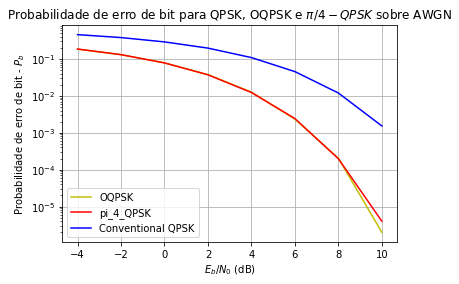

In [111]:
N = 1000000
EbN0dB = np.arange(-4,11,2) # Eb/N0 relacao sinal ruido
OF = 8 # Fator de Oversampling 
Fc = 800 
Fs = OF*Fc
SER_QPSK = np.zeros(len(EbN0dB)) # Relação de erro médio
SER_OQPSK = np.zeros(len(EbN0dB)) # Relação de erro médio
SER_pi_4_QPSK = np.zeros(len(EbN0dB)) # Relação de erro médio

EbN0dB = np.arange(start=-4, stop=12, step=2)
M = 4
in_sym=np.random.randint(0, M, size=N)

const_ref_qpsk = MPSK_reference(M)
k=np.log2(M)
EsN0dBs = 10*np.log10(k)+EbN0dB

modulatedSyms_qpsk = MPSK_mapping(in_sym, const_ref_qpsk)
bitstream = np.random.randint(2, size=N)
s_oqpsk = oqpsk_mod(bitstream, Fc, OF)['s(t)'] # Modulação OQPSK
s_pi_4_qpsk = pi_4_qpsk_mod(bitstream, Fc, OF)['s(t)'] # Modulação pi_4_QPSK

for i, EbN0 in enumerate(EbN0dB):
    r_qpsk = awgn(modulatedSyms_qpsk, EbN0)        
    r_oqpsk = awgn(s_oqpsk, EbN0, OF)
    r_pi_4_qpsk = awgn(s_pi_4_qpsk, EbN0, OF)
    r_qpsk_bits = iqDetector(r_qpsk, const_ref_qpsk)
    r_oqpsk_bits = oqpsk_dem(r_oqpsk, Fc, OF)['bits_out']
    r_pi_4_qpsk_bits = pi_4_qpsk_dem(r_pi_4_qpsk, Fc, OF)['bits_out']
    SER_QPSK[i] = np.sum(r_qpsk_bits != in_sym)/N # Symbol error rate computation
    SER_OQPSK[i] = np.sum(bitstream != r_oqpsk_bits)/N
    SER_pi_4_QPSK[i] = np.sum(bitstream != r_pi_4_qpsk_bits)/N

plt.figure(0)
plt.semilogy(EbN0dB,SER_OQPSK,'y',label='OQPSK')
plt.semilogy(EbN0dB,SER_pi_4_QPSK,'r-',label='pi_4_QPSK')
plt.semilogy(EbN0dB,SER_QPSK,'b-',label='Conventional QPSK')
plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Probabilidade de erro de bit - $P_b$')
plt.title('Probabilidade de erro de bit para QPSK, OQPSK e $\pi/4-QPSK$ sobre AWGN')
plt.grid()
plt.legend()
plt.show()
